In [3]:
#+.+
import numpy as np 
import torch
import torch.nn as nn 
import torch.optim as optim
import pickle as pkl
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

SET-UP

X_train shape:  (104000, 1600)
Y_train shape:  (104000,)
Train samples:  104000
Critical samples:  30000
Test samples:  26000


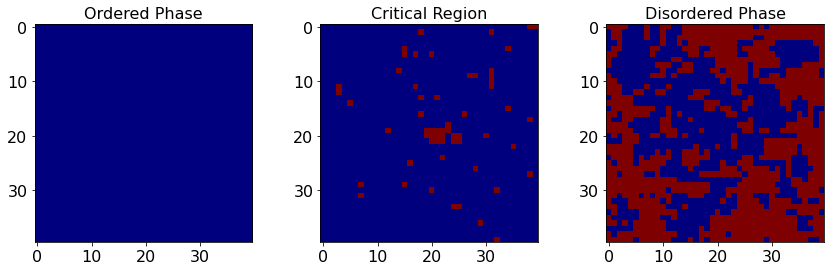

In [4]:
#ISING MODEL PARAMETERS
L=40 #linear system size 
J=-1.0 #Ising interaction, not actually necessary
T=np.linspace(0.25,4.0,16) #temperatures, not actually necessary
Tc=2.26 #critical temperature, not actually necessary

#DATA
data=pkl.load(open("Ising2DFM_reSample_L40_T=All.pkl","rb"))
data=np.unpackbits(data).astype(int).reshape(-1,1600)
data[np.where(data==0)]=-1 #map 0 state to -1 (Ising variable takes +/-1 values), not actually necessary (but useful if one wants to conduct further studies involving the Hamiltonian)
#print("data ", data)
#print(data.shape)

#LABELS 
labels=pkl.load(open("Ising2DFM_reSample_L40_T=All_labels.pkl","rb")) #1: ordered, 0: disordered
#print("labels ", labels)

#DIVIDE DATA INTO ORDERED, CRITICAL, DISORDERED
X_ordered=data[:70000,:]
Y_ordered=labels[:70000]  
#print(Y_ordered)
X_critical=data[70000:100000,:]
Y_critical=labels[70000:100000]
#print(Y_critical)
X_disordered=data[100000:,:]
Y_disordered=labels[100000:]
#print(Y_disordered)
del data,labels #delete original arrays

#TRAINING AND TEST DATA SETS ON ORDERED & DISORDERED STATES
X=np.concatenate((X_ordered,X_disordered))
Y=np.concatenate((Y_ordered,Y_disordered))
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=0.8,test_size=0.2) #train on 80% of this data
X=np.concatenate((X_critical,X)) #retrieve full data set, not really necessary
Y=np.concatenate((Y_critical,Y)) #retrieve full labels set, not really necessary

#SANITY CHECKS 
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("Train samples: ", X_train.shape[0])
print("Critical samples: ", X_critical.shape[0])
print("Test samples: ", X_test.shape[0])

#VISUALIZATION
cmap_args=dict(cmap='jet')
fig,axarr=plt.subplots(nrows=1,ncols=3)
axarr[0].imshow(X_ordered[3500].reshape(L,L),**cmap_args)
axarr[0].set_title("Ordered Phase",fontsize=16)
axarr[0].tick_params(labelsize=16)
axarr[1].imshow(X_critical[1500].reshape(L,L),**cmap_args)
axarr[1].set_title("Critical Region",fontsize=16)
axarr[1].tick_params(labelsize=16)
im=axarr[2].imshow(X_disordered[3000].reshape(L,L),**cmap_args)
axarr[2].set_title("Disordered Phase",fontsize=16)
axarr[2].tick_params(labelsize=16)
fig.subplots_adjust(right=2.0)
plt.show()

MODEL

In [5]:
#TESTING PERFORMANCE (ACCURACY) VS. #MAX ITERATIONS
torch.manual_seed(42) #SEED 42

train_accuracies=[]
test_accuracies=[]
crit_accuracies=[]
max_iters=[]

for max_iter in range(0,1050,50):
    
    max_iters.append(max_iter)
    
    #DEFINE LOG REG MODEL 
    class LogReg(nn.Module):
        def __init__(self,input_dim): 
            super(LogReg,self).__init__()
            self.linear=nn.Linear(input_dim,1) #outputs value of dim. 1
        
        def forward(self,x): #passes input through linear layer and apply sigmoid activation function to produce output
            return torch.sigmoid(self.linear(x)) #sigmoid function
            
    #LOSS FUNCTION AND OPTIMIZER   
    model=LogReg(input_dim=X_train.shape[1]) #instance of LogReg class created
    criterion=nn.BCELoss() #Binary Cross Entropy Loss used as loss function
    optimizer=optim.LBFGS(model.parameters(),lr=0.01,max_iter=max_iter)

    inputs=torch.tensor(X_train,dtype=torch.float32) #convert to PyTorch tensors
    labels=torch.tensor(Y_train,dtype=torch.float32)

    #L-BFGS OPTIMIZATION CLOSURE
    def closure():
        optimizer.zero_grad()
        outputs=model(inputs)
        loss=criterion(outputs,labels.view(-1,1))
        loss.backward()
        return loss

    #OPTIMIZATION
    optimizer.step(closure)
            
    #EVALUATION ON TRAINING DATA
    with torch.no_grad(): 
        inputs=torch.tensor(X_train,dtype=torch.float32)
        labels=torch.tensor(Y_train,dtype=torch.float32)
        outputs=model(inputs) #get model predictions
        predicted=(outputs>=0.5).float() #if >=0.5, prediction class 1, otherwise 0
        accuracy=(predicted==labels.view(-1,1)).sum().item()/len(labels)
        print(f"Accuracy on training data: {accuracy: .4%}")
        train_accuracies.append(accuracy) 
        
    #EVALUATION ON TEST DATA
    with torch.no_grad(): 
        inputs=torch.tensor(X_test,dtype=torch.float32)
        labels=torch.tensor(Y_test,dtype=torch.float32)
        outputs=model(inputs) #get model predictions
        predicted=(outputs>=0.5).float() #if >=0.5, prediction class 1, otherwise 0
        accuracy=(predicted==labels.view(-1,1)).sum().item()/len(labels)
        print(f"Accuracy on test data: {accuracy: .4%}")
        test_accuracies.append(accuracy)
        
    #EVALUATION ON CRITICAL DATA
    with torch.no_grad(): 
        inputs=torch.tensor(X_critical,dtype=torch.float32)
        labels=torch.tensor(Y_critical,dtype=torch.float32)
        outputs=model(inputs) #get model predictions
        predicted=(outputs>=0.5).float() #if >=0.5, prediction class 1, otherwise 0
        accuracy=(predicted==labels.view(-1,1)).sum().item()/len(labels)
        print(f"Accuracy on critical data: {accuracy: .4%}\n")
        crit_accuracies.append(accuracy)
        



Accuracy on training data:  50.6202%
Accuracy on test data:  50.6038%
Accuracy on critical data:  49.5633%

Accuracy on training data:  52.1538%
Accuracy on test data:  51.4462%
Accuracy on critical data:  52.3267%

Accuracy on training data:  50.1510%
Accuracy on test data:  49.7192%
Accuracy on critical data:  49.6033%

Accuracy on training data:  50.3702%
Accuracy on test data:  49.9808%
Accuracy on critical data:  50.5633%

Accuracy on training data:  70.3894%
Accuracy on test data:  68.6923%
Accuracy on critical data:  63.1233%

Accuracy on training data:  71.2308%
Accuracy on test data:  69.4962%
Accuracy on critical data:  62.0233%

Accuracy on training data:  70.8269%
Accuracy on test data:  68.6154%
Accuracy on critical data:  63.5600%

Accuracy on training data:  71.1202%
Accuracy on test data:  68.6115%
Accuracy on critical data:  63.3867%

Accuracy on training data:  71.1606%
Accuracy on test data:  68.6654%
Accuracy on critical data:  63.1667%

Accuracy on training data:  

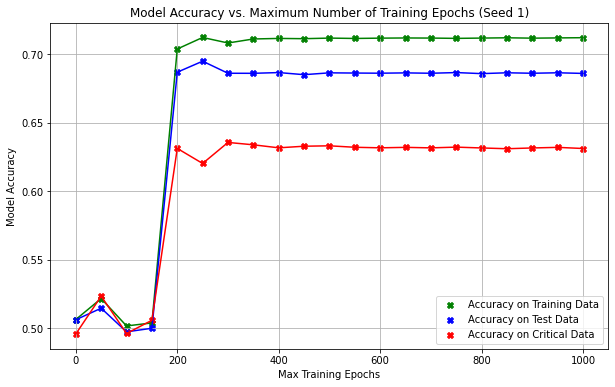

In [6]:
#SEED 42
plt.figure(figsize=(10, 6))
plt.scatter(max_iters,train_accuracies,c="green",marker="X",label="Accuracy on Training Data")
plt.scatter(max_iters,test_accuracies,c="blue",marker="X",label="Accuracy on Test Data")
plt.scatter(max_iters,crit_accuracies,c="red",marker="X",label="Accuracy on Critical Data")
plt.plot(max_iters,train_accuracies,c="green")
plt.plot(max_iters,test_accuracies,c="blue")
plt.plot(max_iters,crit_accuracies,c="red")
plt.xlabel("Max Training Epochs")
plt.ylabel("Model Accuracy")
plt.title("Model Accuracy vs. Maximum Number of Training Epochs (Seed 1)")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
#ZOOMED INTO 0-400 MAX_ITERATIONS
torch.manual_seed(42) #SEED 42

train_accuracies=[]
test_accuracies=[]
crit_accuracies=[]
max_iters=[]

for max_iter in range(0,425,25):
    
    max_iters.append(max_iter)
    
    #DEFINE LOG REG MODEL 
    class LogReg(nn.Module):
        def __init__(self,input_dim): 
            super(LogReg,self).__init__()
            self.linear=nn.Linear(input_dim,1) #outputs value of dim. 1
        
        def forward(self,x): #passes input through linear layer and apply sigmoid activation function to produce output
            return torch.sigmoid(self.linear(x)) #sigmoid function
            
    #LOSS FUNCTION AND OPTIMIZER   
    model=LogReg(input_dim=X_train.shape[1]) #instance of LogReg class created
    criterion=nn.BCELoss() #Binary Cross Entropy Loss used as loss function
    optimizer=optim.LBFGS(model.parameters(),lr=0.01,max_iter=max_iter)

    inputs=torch.tensor(X_train,dtype=torch.float32) #convert to PyTorch tensors
    labels=torch.tensor(Y_train,dtype=torch.float32)

    #L-BFGS OPTIMIZATION CLOSURE
    def closure():
        optimizer.zero_grad()
        outputs=model(inputs)
        loss=criterion(outputs,labels.view(-1,1))
        loss.backward()
        return loss

    #OPTIMIZATION
    optimizer.step(closure)
            
    #EVALUATION ON TRAINING DATA
    with torch.no_grad(): 
        inputs=torch.tensor(X_train,dtype=torch.float32)
        labels=torch.tensor(Y_train,dtype=torch.float32)
        outputs=model(inputs) #get model predictions
        predicted=(outputs>=0.5).float() #if >=0.5, prediction class 1, otherwise 0
        accuracy=(predicted==labels.view(-1,1)).sum().item()/len(labels)
        print(f"Accuracy on training data: {accuracy: .4%}")
        train_accuracies.append(accuracy) 
        
    #EVALUATION ON TEST DATA
    with torch.no_grad(): 
        inputs=torch.tensor(X_test,dtype=torch.float32)
        labels=torch.tensor(Y_test,dtype=torch.float32)
        outputs=model(inputs) #get model predictions
        predicted=(outputs>=0.5).float() #if >=0.5, prediction class 1, otherwise 0
        accuracy=(predicted==labels.view(-1,1)).sum().item()/len(labels)
        print(f"Accuracy on test data: {accuracy: .4%}")
        test_accuracies.append(accuracy)
        
    #EVALUATION ON CRITICAL DATA
    with torch.no_grad(): 
        inputs=torch.tensor(X_critical,dtype=torch.float32)
        labels=torch.tensor(Y_critical,dtype=torch.float32)
        outputs=model(inputs) #get model predictions
        predicted=(outputs>=0.5).float() #if >=0.5, prediction class 1, otherwise 0
        accuracy=(predicted==labels.view(-1,1)).sum().item()/len(labels)
        print(f"Accuracy on critical data: {accuracy: .4%}\n")
        crit_accuracies.append(accuracy)

Accuracy on training data:  50.6202%
Accuracy on test data:  50.6038%
Accuracy on critical data:  49.5633%

Accuracy on training data:  51.8471%
Accuracy on test data:  51.3346%
Accuracy on critical data:  50.9967%

Accuracy on training data:  50.2538%
Accuracy on test data:  49.9269%
Accuracy on critical data:  49.6567%

Accuracy on training data:  50.3144%
Accuracy on test data:  50.0231%
Accuracy on critical data:  49.8833%

Accuracy on training data:  51.2519%
Accuracy on test data:  50.7385%
Accuracy on critical data:  52.2733%

Accuracy on training data:  50.1154%
Accuracy on test data:  49.9500%
Accuracy on critical data:  51.6400%

Accuracy on training data:  50.3856%
Accuracy on test data:  50.3385%
Accuracy on critical data:  52.2567%

Accuracy on training data:  70.0683%
Accuracy on test data:  70.0654%
Accuracy on critical data:  54.4733%

Accuracy on training data:  71.6750%
Accuracy on test data:  70.3077%
Accuracy on critical data:  59.5867%

Accuracy on training data:  

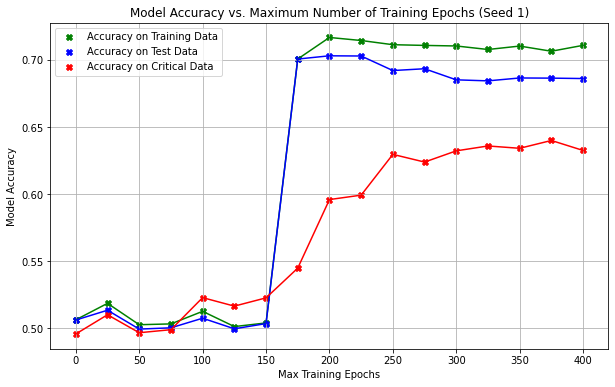

In [8]:
#SEED 42
plt.figure(figsize=(10, 6))
plt.scatter(max_iters,train_accuracies,c="green",marker="X",label="Accuracy on Training Data")
plt.scatter(max_iters,test_accuracies,c="blue",marker="X",label="Accuracy on Test Data")
plt.scatter(max_iters,crit_accuracies,c="red",marker="X",label="Accuracy on Critical Data")
plt.plot(max_iters,train_accuracies,c="green")
plt.plot(max_iters,test_accuracies,c="blue")
plt.plot(max_iters,crit_accuracies,c="red")
plt.xlabel("Max Training Epochs")
plt.ylabel("Model Accuracy")
plt.title("Model Accuracy vs. Maximum Number of Training Epochs (Seed 1)")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
#ZOOMED INTO 0-400 MAX_ITERATIONS
torch.manual_seed(43) #SEED 43

train_accuracies=[]
test_accuracies=[]
crit_accuracies=[]
max_iters=[]

for max_iter in range(0,425,25):
    
    max_iters.append(max_iter)
    
    #DEFINE LOG REG MODEL 
    class LogReg(nn.Module):
        def __init__(self,input_dim): 
            super(LogReg,self).__init__()
            self.linear=nn.Linear(input_dim,1) #outputs value of dim. 1
        
        def forward(self,x): #passes input through linear layer and apply sigmoid activation function to produce output
            return torch.sigmoid(self.linear(x)) #sigmoid function
            
    #LOSS FUNCTION AND OPTIMIZER   
    model=LogReg(input_dim=X_train.shape[1]) #instance of LogReg class created
    criterion=nn.BCELoss() #Binary Cross Entropy Loss used as loss function
    optimizer=optim.LBFGS(model.parameters(),lr=0.01,max_iter=max_iter)

    inputs=torch.tensor(X_train,dtype=torch.float32) #convert to PyTorch tensors
    labels=torch.tensor(Y_train,dtype=torch.float32)

    #L-BFGS OPTIMIZATION CLOSURE
    def closure():
        optimizer.zero_grad()
        outputs=model(inputs)
        loss=criterion(outputs,labels.view(-1,1))
        loss.backward()
        return loss

    #OPTIMIZATION
    optimizer.step(closure)
            
    #EVALUATION ON TRAINING DATA
    with torch.no_grad(): 
        inputs=torch.tensor(X_train,dtype=torch.float32)
        labels=torch.tensor(Y_train,dtype=torch.float32)
        outputs=model(inputs) #get model predictions
        predicted=(outputs>=0.5).float() #if >=0.5, prediction class 1, otherwise 0
        accuracy=(predicted==labels.view(-1,1)).sum().item()/len(labels)
        print(f"Accuracy on training data: {accuracy: .4%}")
        train_accuracies.append(accuracy) 
        
    #EVALUATION ON TEST DATA
    with torch.no_grad(): 
        inputs=torch.tensor(X_test,dtype=torch.float32)
        labels=torch.tensor(Y_test,dtype=torch.float32)
        outputs=model(inputs) #get model predictions
        predicted=(outputs>=0.5).float() #if >=0.5, prediction class 1, otherwise 0
        accuracy=(predicted==labels.view(-1,1)).sum().item()/len(labels)
        print(f"Accuracy on test data: {accuracy: .4%}")
        test_accuracies.append(accuracy)
        
    #EVALUATION ON CRITICAL DATA
    with torch.no_grad(): 
        inputs=torch.tensor(X_critical,dtype=torch.float32)
        labels=torch.tensor(Y_critical,dtype=torch.float32)
        outputs=model(inputs) #get model predictions
        predicted=(outputs>=0.5).float() #if >=0.5, prediction class 1, otherwise 0
        accuracy=(predicted==labels.view(-1,1)).sum().item()/len(labels)
        print(f"Accuracy on critical data: {accuracy: .4%}\n")
        crit_accuracies.append(accuracy)

Accuracy on training data:  49.5144%
Accuracy on test data:  50.0154%
Accuracy on critical data:  49.5733%

Accuracy on training data:  49.0663%
Accuracy on test data:  49.0769%
Accuracy on critical data:  49.8400%

Accuracy on training data:  49.5817%
Accuracy on test data:  49.1808%
Accuracy on critical data:  50.3767%

Accuracy on training data:  52.2144%
Accuracy on test data:  51.4577%
Accuracy on critical data:  53.9467%

Accuracy on training data:  52.2529%
Accuracy on test data:  51.8154%
Accuracy on critical data:  52.5733%

Accuracy on training data:  52.2894%
Accuracy on test data:  51.6462%
Accuracy on critical data:  53.9533%

Accuracy on training data:  49.9885%
Accuracy on test data:  49.8846%
Accuracy on critical data:  50.8667%

Accuracy on training data:  68.9029%
Accuracy on test data:  68.6500%
Accuracy on critical data:  53.2400%

Accuracy on training data:  71.0885%
Accuracy on test data:  69.6462%
Accuracy on critical data:  61.1933%

Accuracy on training data:  

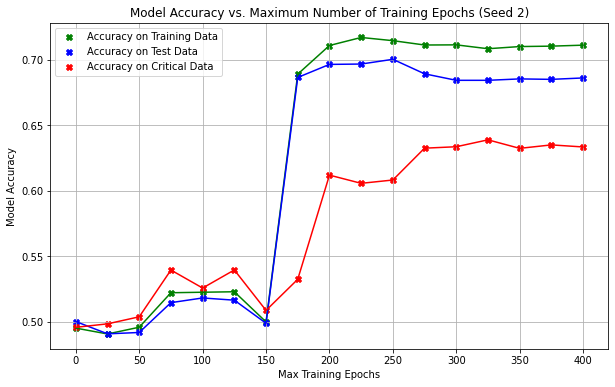

In [10]:
#SEED 43
plt.figure(figsize=(10, 6))
plt.scatter(max_iters,train_accuracies,c="green",marker="X",label="Accuracy on Training Data")
plt.scatter(max_iters,test_accuracies,c="blue",marker="X",label="Accuracy on Test Data")
plt.scatter(max_iters,crit_accuracies,c="red",marker="X",label="Accuracy on Critical Data")
plt.plot(max_iters,train_accuracies,c="green")
plt.plot(max_iters,test_accuracies,c="blue")
plt.plot(max_iters,crit_accuracies,c="red")
plt.xlabel("Max Training Epochs")
plt.ylabel("Model Accuracy")
plt.title("Model Accuracy vs. Maximum Number of Training Epochs (Seed 2)")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
#L2 REGULARIZATION TEST
torch.manual_seed(42) #SEED 42

train_accuracies=[]
test_accuracies=[]
crit_accuracies=[]
lambdas=np.logspace(-7,-1,13)

for lamb in lambdas:
    #DEFINE LOG REG MODEL 
    class LogReg(nn.Module):
        def __init__(self,input_dim): 
            super(LogReg,self).__init__()
            self.linear=nn.Linear(input_dim,1) #outputs value of dim. 1
        
        def forward(self,x): #passes input through linear layer and apply sigmoid activation function to produce output
            return torch.sigmoid(self.linear(x)) #sigmoid function
        
    def l2_loss(model,criterion,inputs,labels,lambd=lamb):
        outputs=model(inputs)
        loss=criterion(outputs,labels.view(-1,1))
        l2_reg=torch.tensor(0.)
        for param in model.parameters():
            l2_reg+=torch.norm(param)
        loss+=lambd*l2_reg
        return loss
                
    #LOSS FUNCTION AND OPTIMIZER   
    model=LogReg(input_dim=X_train.shape[1]) #instance of LogReg class created
    criterion=nn.BCELoss() #Binary Cross Entropy Loss used as loss function
    optimizer=optim.LBFGS(model.parameters(),lr=0.01,max_iter=300)

    inputs=torch.tensor(X_train,dtype=torch.float32) #convert to PyTorch tensors
    labels=torch.tensor(Y_train,dtype=torch.float32)

    #L-BFGS OPTIMIZATION CLOSURE
    def closure():
        optimizer.zero_grad()
        outputs=model(inputs)
        loss=l2_loss(model,criterion,inputs,labels)
        loss.backward()
        return loss

    #OPTIMIZATION
    optimizer.step(closure)
            
    #EVALUATION ON TRAINING DATA
    with torch.no_grad(): 
        inputs=torch.tensor(X_train,dtype=torch.float32)
        labels=torch.tensor(Y_train,dtype=torch.float32)
        outputs=model(inputs) #get model predictions
        predicted=(outputs>=0.5).float() #if >=0.5, prediction class 1, otherwise 0
        accuracy=(predicted==labels.view(-1,1)).sum().item()/len(labels)
        print(f"Accuracy on training data: {accuracy: .4%}")
        train_accuracies.append(accuracy) 
        
    #EVALUATION ON TEST DATA
    with torch.no_grad(): 
        inputs=torch.tensor(X_test,dtype=torch.float32)
        labels=torch.tensor(Y_test,dtype=torch.float32)
        outputs=model(inputs) #get model predictions
        predicted=(outputs>=0.5).float() #if >=0.5, prediction class 1, otherwise 0
        accuracy=(predicted==labels.view(-1,1)).sum().item()/len(labels)
        print(f"Accuracy on test data: {accuracy: .4%}")
        test_accuracies.append(accuracy)
        
    #EVALUATION ON CRITICAL DATA
    with torch.no_grad(): 
        inputs=torch.tensor(X_critical,dtype=torch.float32)
        labels=torch.tensor(Y_critical,dtype=torch.float32)
        outputs=model(inputs) #get model predictions
        predicted=(outputs>=0.5).float() #if >=0.5, prediction class 1, otherwise 0
        accuracy=(predicted==labels.view(-1,1)).sum().item()/len(labels)
        print(f"Accuracy on critical data: {accuracy: .4%}\n")
        crit_accuracies.append(accuracy)

Accuracy on training data:  71.2913%
Accuracy on test data:  69.0077%
Accuracy on critical data:  62.9667%

Accuracy on training data:  71.0635%
Accuracy on test data:  68.5346%
Accuracy on critical data:  63.3200%

Accuracy on training data:  71.1192%
Accuracy on test data:  68.9769%
Accuracy on critical data:  62.5900%

Accuracy on training data:  71.3000%
Accuracy on test data:  69.0269%
Accuracy on critical data:  62.4567%

Accuracy on training data:  70.6740%
Accuracy on test data:  68.2269%
Accuracy on critical data:  64.0967%

Accuracy on training data:  70.9615%
Accuracy on test data:  68.7077%
Accuracy on critical data:  63.2000%

Accuracy on training data:  70.7913%
Accuracy on test data:  68.5269%
Accuracy on critical data:  63.5533%

Accuracy on training data:  71.1385%
Accuracy on test data:  68.6808%
Accuracy on critical data:  63.4133%

Accuracy on training data:  71.1702%
Accuracy on test data:  68.7692%
Accuracy on critical data:  63.4333%

Accuracy on training data:  

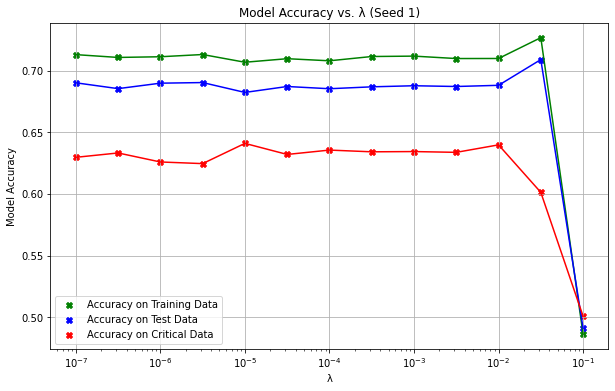

In [12]:
#SEED 42
plt.figure(figsize=(10, 6))
plt.scatter(lambdas,train_accuracies,c="green",marker="X",label="Accuracy on Training Data")
plt.scatter(lambdas,test_accuracies,c="blue",marker="X",label="Accuracy on Test Data")
plt.scatter(lambdas,crit_accuracies,c="red",marker="X",label="Accuracy on Critical Data")
plt.plot(lambdas,train_accuracies,c="green")
plt.plot(lambdas,test_accuracies,c="blue")
plt.plot(lambdas,crit_accuracies,c="red")
plt.xlabel("\u03BB")
plt.ylabel("Model Accuracy")
plt.title("Model Accuracy vs. \u03BB (Seed 1)")
plt.legend()
plt.grid(True)
plt.xscale("log")
plt.show()

In [13]:
#L2 REGULARIZATION TEST
torch.manual_seed(43) #SEED 43

train_accuracies=[]
test_accuracies=[]
crit_accuracies=[]
lambdas=np.logspace(-7,-1,13)

for lamb in lambdas:
    #DEFINE LOG REG MODEL 
    class LogReg(nn.Module):
        def __init__(self,input_dim): 
            super(LogReg,self).__init__()
            self.linear=nn.Linear(input_dim,1) #outputs value of dim. 1
        
        def forward(self,x): #passes input through linear layer and apply sigmoid activation function to produce output
            return torch.sigmoid(self.linear(x)) #sigmoid function
        
    def l2_loss(model,criterion,inputs,labels,lambd=lamb):
        outputs=model(inputs)
        loss=criterion(outputs,labels.view(-1,1))
        l2_reg=torch.tensor(0.)
        for param in model.parameters():
            l2_reg+=torch.norm(param)
        loss+=lambd*l2_reg
        return loss
                
    #LOSS FUNCTION AND OPTIMIZER   
    model=LogReg(input_dim=X_train.shape[1]) #instance of LogReg class created
    criterion=nn.BCELoss() #Binary Cross Entropy Loss used as loss function
    optimizer=optim.LBFGS(model.parameters(),lr=0.01,max_iter=300)

    inputs=torch.tensor(X_train,dtype=torch.float32) #convert to PyTorch tensors
    labels=torch.tensor(Y_train,dtype=torch.float32)

    #L-BFGS OPTIMIZATION CLOSURE
    def closure():
        optimizer.zero_grad()
        outputs=model(inputs)
        loss=l2_loss(model,criterion,inputs,labels)
        loss.backward()
        return loss

    #OPTIMIZATION
    optimizer.step(closure)
            
    #EVALUATION ON TRAINING DATA
    with torch.no_grad(): 
        inputs=torch.tensor(X_train,dtype=torch.float32)
        labels=torch.tensor(Y_train,dtype=torch.float32)
        outputs=model(inputs) #get model predictions
        predicted=(outputs>=0.5).float() #if >=0.5, prediction class 1, otherwise 0
        accuracy=(predicted==labels.view(-1,1)).sum().item()/len(labels)
        print(f"Accuracy on training data: {accuracy: .4%}")
        train_accuracies.append(accuracy) 
        
    #EVALUATION ON TEST DATA
    with torch.no_grad(): 
        inputs=torch.tensor(X_test,dtype=torch.float32)
        labels=torch.tensor(Y_test,dtype=torch.float32)
        outputs=model(inputs) #get model predictions
        predicted=(outputs>=0.5).float() #if >=0.5, prediction class 1, otherwise 0
        accuracy=(predicted==labels.view(-1,1)).sum().item()/len(labels)
        print(f"Accuracy on test data: {accuracy: .4%}")
        test_accuracies.append(accuracy)
        
    #EVALUATION ON CRITICAL DATA
    with torch.no_grad(): 
        inputs=torch.tensor(X_critical,dtype=torch.float32)
        labels=torch.tensor(Y_critical,dtype=torch.float32)
        outputs=model(inputs) #get model predictions
        predicted=(outputs>=0.5).float() #if >=0.5, prediction class 1, otherwise 0
        accuracy=(predicted==labels.view(-1,1)).sum().item()/len(labels)
        print(f"Accuracy on critical data: {accuracy: .4%}\n")
        crit_accuracies.append(accuracy)

Accuracy on training data:  70.9692%
Accuracy on test data:  68.7808%
Accuracy on critical data:  63.3200%

Accuracy on training data:  71.0212%
Accuracy on test data:  68.3500%
Accuracy on critical data:  63.4733%

Accuracy on training data:  71.1106%
Accuracy on test data:  68.8846%
Accuracy on critical data:  63.1467%

Accuracy on training data:  71.1058%
Accuracy on test data:  68.6731%
Accuracy on critical data:  63.4700%

Accuracy on training data:  70.6413%
Accuracy on test data:  68.2962%
Accuracy on critical data:  64.0433%

Accuracy on training data:  70.6510%
Accuracy on test data:  68.0846%
Accuracy on critical data:  64.1833%

Accuracy on training data:  71.0356%
Accuracy on test data:  68.9885%
Accuracy on critical data:  63.1367%

Accuracy on training data:  71.0385%
Accuracy on test data:  68.8385%
Accuracy on critical data:  62.8400%

Accuracy on training data:  70.8356%
Accuracy on test data:  68.3115%
Accuracy on critical data:  63.4567%

Accuracy on training data:  

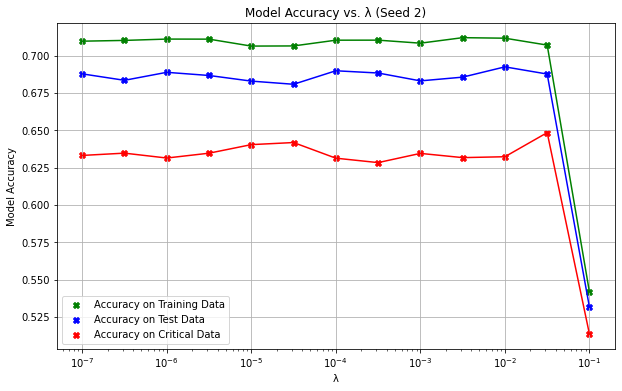

3.1622776601683795e-05


In [14]:
#SEED 43
plt.figure(figsize=(10, 6))
plt.scatter(lambdas,train_accuracies,c="green",marker="X",label="Accuracy on Training Data")
plt.scatter(lambdas,test_accuracies,c="blue",marker="X",label="Accuracy on Test Data")
plt.scatter(lambdas,crit_accuracies,c="red",marker="X",label="Accuracy on Critical Data")
plt.plot(lambdas,train_accuracies,c="green")
plt.plot(lambdas,test_accuracies,c="blue")
plt.plot(lambdas,crit_accuracies,c="red")
plt.xlabel("\u03BB")
plt.ylabel("Model Accuracy")
plt.title("Model Accuracy vs. \u03BB (Seed 2)")
plt.legend()
plt.grid(True)
plt.xscale("log")
plt.show()
#print(lambdas[5])